In [1]:
import os; import pandas as pd; import numpy  as np
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [90]:
path = "../data/tpl/lines_events/"
tra  = pd.read_parquet(path+"traffic.parquet")

## Traffic over Time

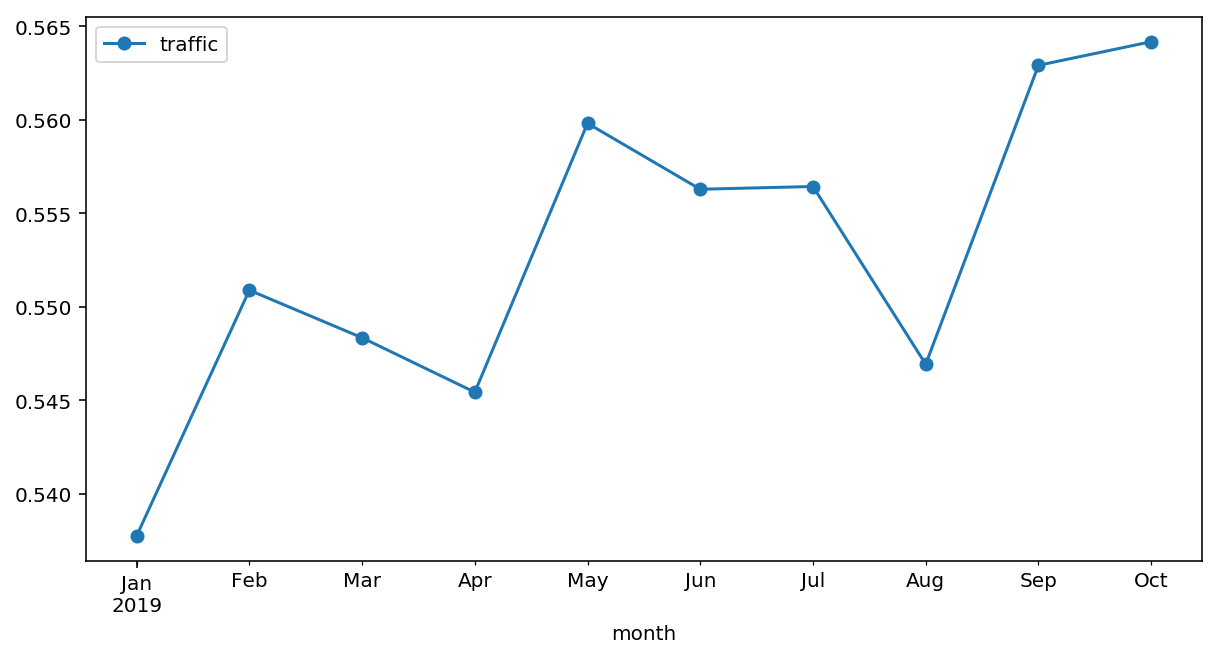

In [91]:
ds = tra.copy()
ds = ds[ds.index.get_level_values(2)>=pd.datetime(2019,1 ,1)]
ds = ds[ds.index.get_level_values(2)<=pd.datetime(2019,10,1)].copy()
ds['month'] = ds.index.get_level_values(2).to_period('M').to_timestamp('M')
fig, ax1 = plt.subplots(1,1, figsize=(10,5))
ds.groupby(['month'])[['traffic']].mean().plot(ax=ax1, marker='o');

## Nationalities of Visiting People

In [ ]:
nat = pd.read_csv("../analysis/nationalities_incoming.csv", parse_dates=['Date']).set_index('Date')
tra = tra.reset_index().set_index('date')
tra[nat.columns] = nat
tra = tra.reset_index().set_index(['fermata', 'weekend', 'date', 'hour'])

peo = pd.read_csv("../analysis/people_total.csv", parse_dates=['date']).set_index(['date', 'hour'])
tra = tra.reset_index().set_index(['date','hour'])
tra[peo.columns] = peo
tra = tra.reset_index().set_index(['fermata', 'weekend', 'date', 'hour'])

In [136]:
ds = tra.dropna().copy()

ds['tot_car'] = ds['Road'] + ds['Highway']

for col in nat.columns:
    ds[col] = ds[col] * ds['tot_car'] / 100
    
    # Standardize
    ds[col] = ds[col] / ds[col].std() 

In [140]:
print('All days')
reg = smf.ols(" traffic ~ Italy + Switzerland", ds.groupby(['date', 'hour']).mean()).fit()
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))
reg.summary().tables[1]

All days
R-squared: 60.14%, N: 467


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2130,0.012,17.303,0.000,0.189,0.237
Italy,-0.1152,0.018,-6.382,0.000,-0.151,-0.080
Switzerland,0.2194,0.017,12.625,0.000,0.185,0.254


### ...

In [29]:
print('Weekdays Only')
reg = smf.ols(" traffic ~ Italy*weekend", ds.reset_index()).fit()
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))
reg.summary().tables[1]

Weekdays Only
R-squared: 0.33%, N: 176,971


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3764,0.014,26.416,0.000,0.349,0.404
Italy,0.0185,0.001,13.538,0.000,0.016,0.021
weekend,0.4277,0.024,17.681,0.000,0.380,0.475
Italy:weekend,-0.0544,0.003,-19.597,0.000,-0.060,-0.049


## Weather and Air Pollution

In [94]:
wea = pd.read_csv("../analysis/air-weather-info.csv", parse_dates=['day'])
wea = wea.set_index(['day', 'hour']).drop(['Ora', 'Data', 'Data e ora'],axis=1)
wea.rename({'Prec. [mm]':'prec', 'Temp. [°C]':'temp'},axis=1, inplace=True)

In [95]:
tra = tra.reset_index()
tra['hour'] = tra['hour'].astype(int)
tra = tra.set_index(['date', 'hour'])
tra[wea.columns] = wea
tra = tra.reset_index().set_index(['fermata', 'weekend', 'date', 'hour'])
ds = tra.copy()

In [96]:
print('All days')
reg = smf.ols(" traffic ~ prec + temp", ds.groupby(['date', 'hour']).mean()).fit()
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))
reg.summary().tables[1]

All days
R-squared: 2.77%, N: 6,433


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4592,0.005,100.355,0.000,0.450,0.468
prec,-0.0026,0.015,-0.177,0.859,-0.031,0.026
temp,0.0037,0.000,13.516,0.000,0.003,0.004


## Hotel Guests

In [97]:
hot = pd.read_csv("../analysis/hotel_guests.csv", parse_dates=['date']).set_index('date')
tra = tra.reset_index().set_index(['date'])
tra['hotel_guests'] = hot
tra = tra.reset_index().set_index(['fermata', 'weekend', 'date', 'hour'])
ds = tra.copy()

In [98]:
print('All days')
reg = smf.ols(" traffic ~ hotel_guests", ds.groupby(['date']).mean()).fit()
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))
reg.summary().tables[1]

All days
R-squared: 1.88%, N: 318


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5229,0.010,53.810,0.000,0.504,0.542
hotel_guests,5.911e-05,2.4e-05,2.458,0.015,1.18e-05,0.000


## Parkings

In [99]:
par = pd.read_csv("../analysis/parking-info.csv", parse_dates=['data']).drop(['Unnamed: 0'],axis=1)
par = par.set_index(['data', 'hour'])

In [100]:
tra = tra.reset_index()
tra['hour'] = tra['hour'].astype(int)
tra = tra.set_index(['date', 'hour'])
tra['parkings'] = par.groupby(['data', 'hour'])['OccupazionePerc'].mean()
tra = tra.reset_index().set_index(['fermata', 'weekend', 'date', 'hour'])
ds = tra.copy()

In [101]:
ds = ds[ds.index.get_level_values(2)>=pd.datetime(2019,1 ,1)]
ds = ds[ds.index.get_level_values(2)<=pd.datetime(2019,10,1)].copy()
ds = ds.dropna(subset=['parkings'])

In [102]:
print('All days')
reg = smf.ols(" traffic ~ parkings", ds.groupby(['date','hour']).mean()).fit()
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))
reg.summary().tables[1]

All days
R-squared: 19.88%, N: 1,971


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3719,0.008,49.076,0.000,0.357,0.387
parkings,0.0040,0.000,22.105,0.000,0.004,0.004


## All Together

In [142]:
var = [
    'Italy', 'Switzerland', #'Germany', 'Netherlands',
    'prec','temp',
    #'hotel_guests',
    'parkings',
]

ds = tra.dropna(subset=var).groupby(['date', 'hour']).mean()

print('All days')
reg = smf.ols(" traffic ~ {0}".format(" + ".join(var)), ds).fit()
print("R-squared: {0:1.2f}%, N: {1:1,.0f}".format(reg.rsquared*100, reg.nobs))
reg.summary().tables[1]

All days
R-squared: 19.17%, N: 467


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.9315,0.348,-2.677,0.008,-1.615,-0.248
Italy,-0.0111,0.006,-1.784,0.075,-0.023,0.001
Switzerland,0.0173,0.005,3.501,0.001,0.008,0.027
prec,0.0073,0.026,0.282,0.778,-0.043,0.058
temp,0.0045,0.001,4.937,0.000,0.003,0.006
parkings,0.0028,0.000,7.090,0.000,0.002,0.004


## Save

In [143]:
tra.to_csv("Traffic_Index.csv")